In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam import interactions
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt

path = '/media/robert/Data_Storage/Data/Ionization/BeamCombining/140umCentral_1e16/'
lam = 0.8
tau = 35.

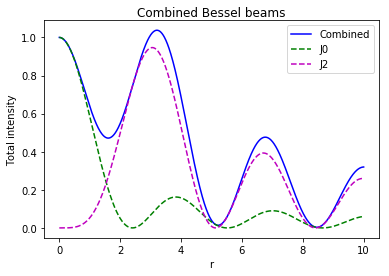

In [2]:
from scipy.special import jn
x = np.linspace(0, 10, 1000)
b = 2.0
j0 = jn(0, x)
j2 = b*jn(2, x)
plt.plot(x, j0**2 + j2**2, 'b', x, j0**2, 'g--', x, j2**2, 'm--')
plt.title('Combined Bessel beams')
plt.xlabel('r')
plt.ylabel('Total intensity')
plt.legend(['Combined', 'J0', 'J2'])
plt.show()

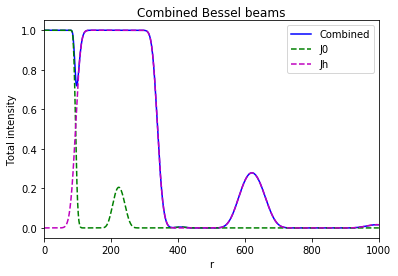

In [3]:
# Code to find transverse plasma density from Bessel
atom = ionization.Ar
ion = {
    'atom' : atom,
    'tau' : tau,
    'type' : 'gaussian'
}
alpha = 0.75
beta = 1.1
order = 1
R0 = 140
Rh = 280
r = np.linspace(0, 1e3, 1000)
ne, nj0, njh = bessel.multimode_transverse_estimate(r, ion, alpha, beta, order, R0, Rh)
plt.plot(r, ne, 'b', r, nj0, 'g--', r, njh, 'm--')
plt.title('Combined Bessel beams')
plt.xlabel('r')
plt.ylabel('Total intensity')
plt.legend(['Combined', 'J0', 'Jh'])
plt.xlim([0, 1000])
plt.show()

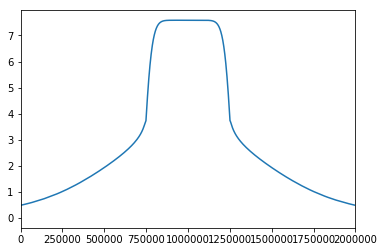

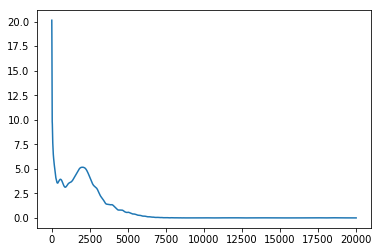

In [4]:
# Create the desired intensity profile
ion = {'atom' : ionization.Ar,
       'tau' : tau,
       'type' : 'gaussian'}
z0 = 0.75e6
zf = 100e6
dz = 0.5e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 100000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, 5, (1+alpha)**2-1, zf)
plt.plot(z, I)
plt.xlim(0, 2e6)
plt.show()
params = {
    'Nr' : 5000,
    'R' : 20e3,
    'w' : 140,
    'lam' : lam
}
r0, E0 = bessel.bessel_expansion(params, z, I)
plt.plot(r0, abs(E0))
plt.show()

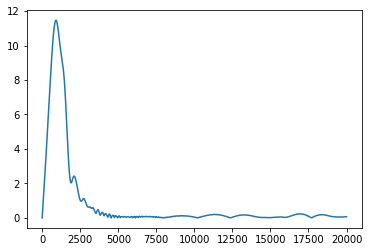

In [5]:
# Create the higher order Bessel mode
sigmaIn = 1e4
sigmaOut = 1e4
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, 5, 0.0, zf)

params = {
    'Nr' : 5000,
    'R' : 20e3,
    'w' : 280,
    'lam' : lam
}
r1, E1 = bessel.bessel_expansion(params, z, I, n=order)
E1 += beta*E1
plt.plot(r1, abs(E1))
plt.show()

In [6]:
pulseParams = {
    'Nx' : 2**11,
    'Ny' : 2**11,
    'Nt' : 2**6,
    'X' : 15e3,
    'Y' : 15e3,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 4,
    'cyl' : True,
    'tau' : tau,
}

plasmaParams = {
    'Nx' : pulseParams['Nx'],
    'Ny' : pulseParams['Ny'],
    'Nz' : 2**8,
    'X' : pulseParams['X'],
    'Y' : pulseParams['Y'],
    'Z' : 2.0e6, 
    'n0' : 0.1,
    'atom' : ionization.Ar,
    'path' : path,
    'load' : False,
    'cyl' : True
}

In [7]:
# Test the higher order Bessel beam
pulseParams['name'] = 'J0Beam'
pulseParams['order'] = 0
pulseParams['r'] = r0
pulseParams['E'] = E0
beam0 = laserbeam.RadialLaser(pulseParams)
pulseParams['name'] = 'J1Beam'
pulseParams['order'] = order
pulseParams['r'] = r1
pulseParams['E'] = E1
beam1 = laserbeam.RadialLaser(pulseParams)

In [8]:
beam0.propagate(np.linspace(0, plasmaParams['Z'], plasmaParams['Nz']), 1.0)
beam1.propagate(np.linspace(0, plasmaParams['Z'], plasmaParams['Nz']), 1.0)

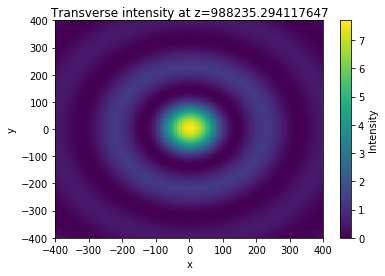

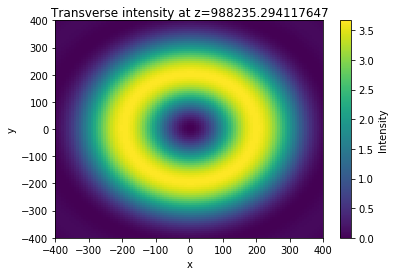

In [9]:
ind = 127
beam0.plot_intensity_at(ind, lim=[-400, 400])
beam1.plot_intensity_at(ind, lim=[-400, 400])

In [10]:
pulseParams['name'] = 'J1Pulse'
pulseParams['order'] = order
pulseParams['r'] = r1
pulseParams['E'] = E1
pulse1 = laserpulse.RadialPulse(pulseParams)
plasmaParams['name'] = 'J1Plasma'
argon1 = plasma.UniformPlasma(plasmaParams)
interactions.pulse_plasma(pulse1, argon1)

In [11]:
pulseParams['name'] = 'J0Pulse'
pulseParams['order'] = 0
pulseParams['r'] = r0
pulseParams['E'] = E0
pulse0 = laserpulse.RadialPulse(pulseParams)
plasmaParams['sourcePath'] = path
plasmaParams['sourceName'] = plasmaParams['name']
plasmaParams['name'] = 'J0Plasma'
argon0 = plasma.ExistingPlasma(plasmaParams)
interactions.pulse_plasma(pulse0, argon0)

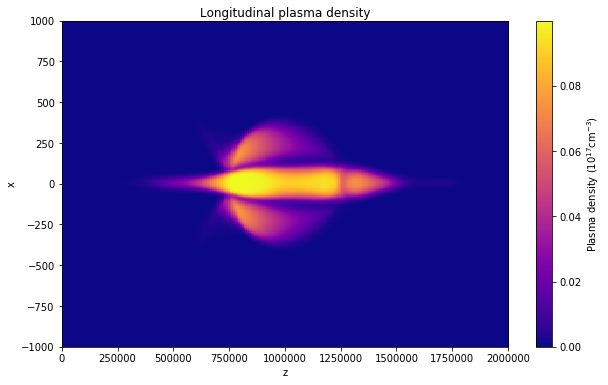

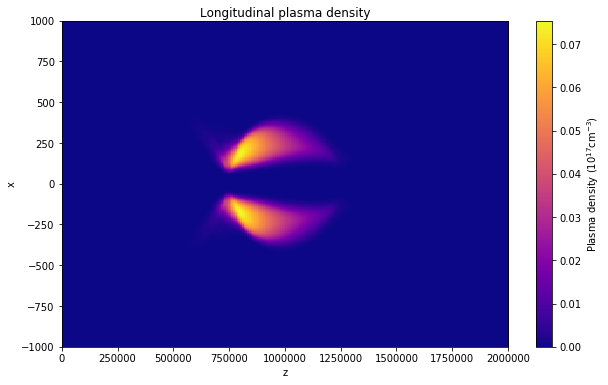

In [12]:
argon0.plot_long_density_center(lim=[-1000, 1000])
argon1.plot_long_density_center(lim=[-1000, 1000])

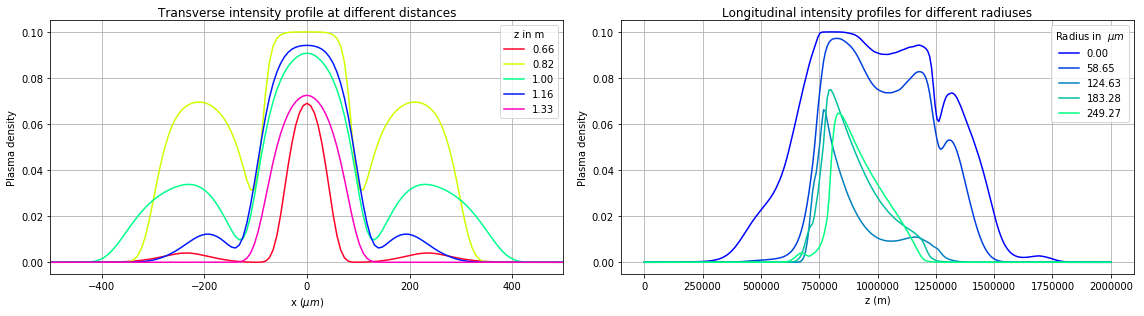

In [13]:
argon0.plot_profiles(5, 50, xlim=[-500, 500])

In [14]:
pulseParams['name'] = 'J1PulseX1.5'
pulseParams['order'] = order
pulseParams['r'] = r1
pulseParams['E'] = E1*1.5
pulse1 = laserpulse.RadialPulse(pulseParams)
plasmaParams['name'] = 'J1PlasmaX1.5'
argon1 = plasma.UniformPlasma(plasmaParams)
interactions.pulse_plasma(pulse1, argon1)

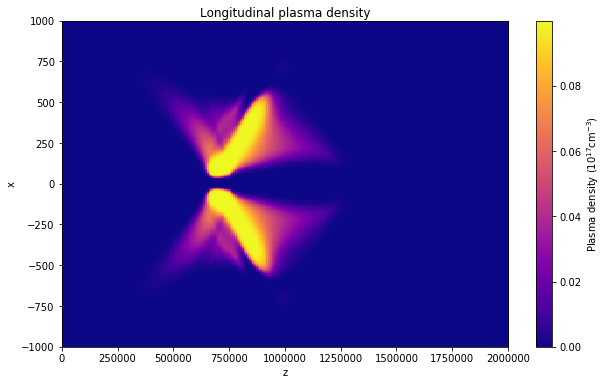

In [15]:
argon1.plot_long_density_center(lim=[-1000, 1000])